# Load Dependencies

In [79]:
# Spark Dependencies
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from math import sqrt
import re

%matplotlib inline
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
sns.set(rc={'figure.figsize':(12,10)})

# Load Loan Dataset into Pyspark Dataframe

In [80]:
my_dataset = spark.read.option('header', True).csv("./loan_data.csv")

# Data Processing
<h3>Exploratory Data Analysis</h3>

In [81]:
# Check if the dataframe has NULL value or not
my_dataset.select(
    [
        count(
            when(isnan(c) | col(c).isNull(), c)
        ).alias(c) for c in my_dataset.columns
    ]
)
my_dataset = my_dataset.na.drop(subset=["Good Loan"])
my_dataset.select(
    [
        count(
            when(isnan(c) | col(c).isNull(), c)
        ).alias(c) for c in my_dataset.columns
    ]
)

for column in my_dataset.columns:
    my_new_column = str(column).lower().strip().replace("/","").replace("?","").replace(" ","_")
    my_dataset = my_dataset.withColumnRenamed(column, my_new_column)

my_dataset = my_dataset.withColumn("type_of_account", col("type_of_account").cast(StringType()))
my_dataset = my_dataset.withColumn("account_history", col("account_history").cast(StringType()))
my_dataset = my_dataset.withColumn("reason_for_the_loan", col("reason_for_the_loan").cast(StringType()))
my_dataset = my_dataset.withColumn("loan_amount", col("loan_amount").cast(IntegerType()))
my_dataset = my_dataset.withColumn("account_savings", col("account_savings").cast(StringType()))
my_dataset = my_dataset.withColumn("employment_history", col("employment_history").cast(StringType()))
my_dataset = my_dataset.withColumn("individual_status", col("individual_status").cast(StringType()))
my_dataset = my_dataset.withColumn("other_loans", col("other_loans").cast(StringType()))
my_dataset = my_dataset.withColumn("security__collateral", col("security__collateral").cast(StringType()))
my_dataset = my_dataset.withColumn("age", col("age").cast(IntegerType()))
my_dataset = my_dataset.withColumn("residence_status", col("residence_status").cast(StringType()))
my_dataset = my_dataset.withColumn("job", col("job").cast(StringType()))
my_dataset = my_dataset.withColumn("completed_other_loan", col("completed_other_loan").cast(StringType()))
my_dataset = my_dataset.withColumn("good_loan", col("good_loan").cast(StringType()))


print(f"My Dataframe Size : {(my_dataset.count(), len(my_dataset.columns))}")

My Dataframe Size : (1001, 14)


# Check Data

In [82]:
my_dataset = my_dataset.filter((col("age")<150) & (col("loan_amount")>0))
my_dataset.describe()
print(f"My Dataframe Size : {(my_dataset.count(), len(my_dataset.columns))}")

My Dataframe Size : (1000, 14)


# Plot Data

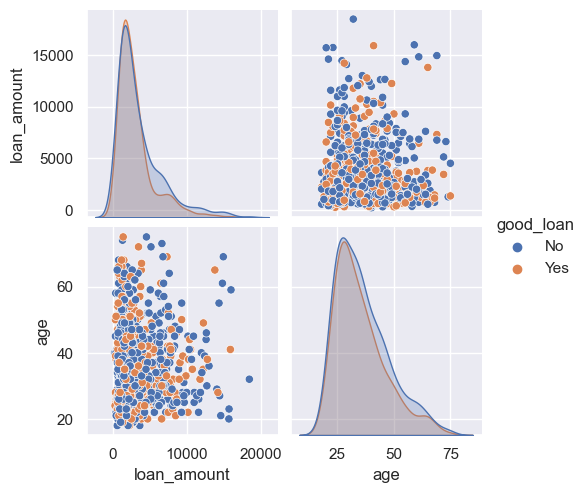

In [83]:
converted_to_pandas = my_dataset.toPandas()

g = sns.pairplot(converted_to_pandas, hue="good_loan")

# Investigating distribution of y i.e. good_loan
We need to plot a countplotto check the distribution of y, if it is immbalanced, then we have to take an action to balance it.

<AxesSubplot:xlabel='good_loan', ylabel='count'>

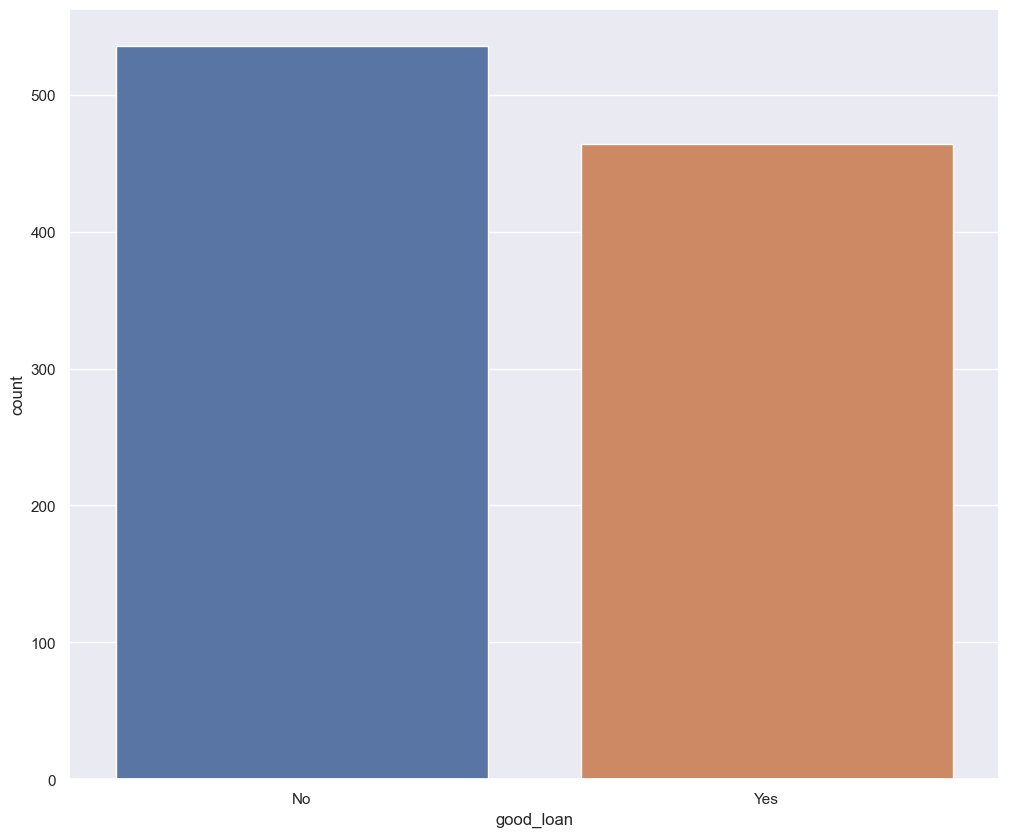

In [84]:
sns.countplot(x="good_loan", data=converted_to_pandas)

Analysing the impact of variables other than numeric ones on output (y)

In [85]:
converted_to_pandas.columns

Index(['type_of_account', 'account_history', 'reason_for_the_loan',
       'loan_amount', 'account_savings', 'employment_history',
       'individual_status', 'other_loans', 'security__collateral', 'age',
       'residence_status', 'job', 'completed_other_loan', 'good_loan'],
      dtype='object')

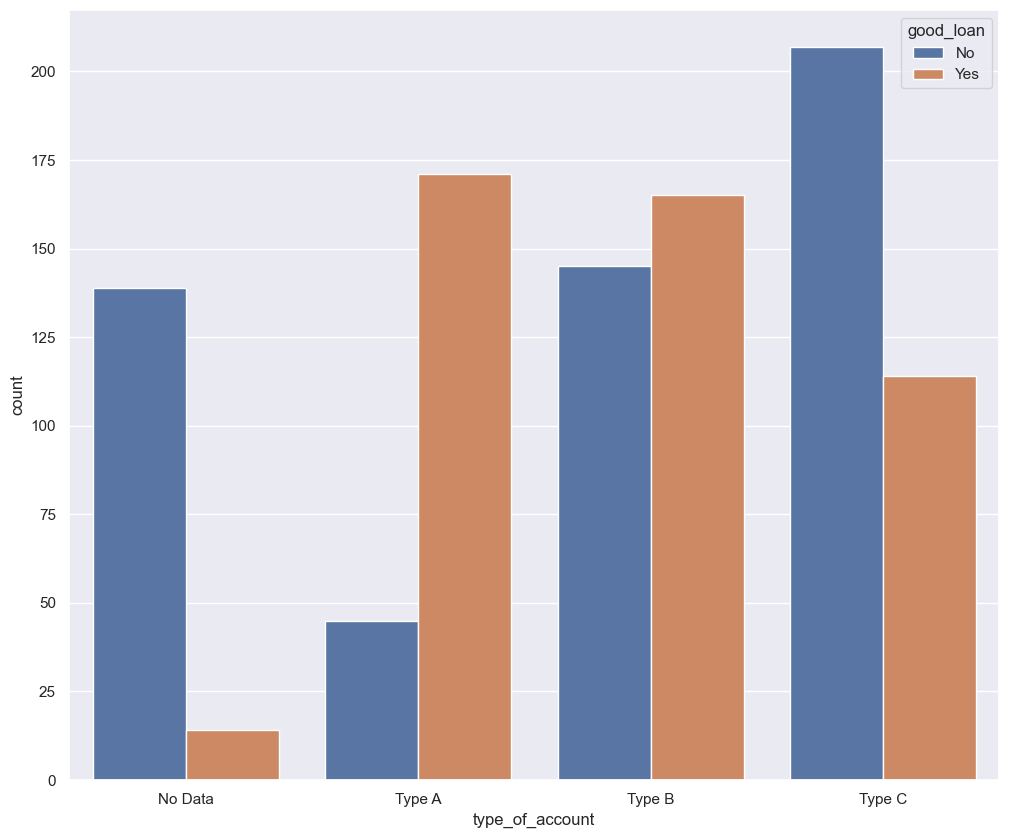

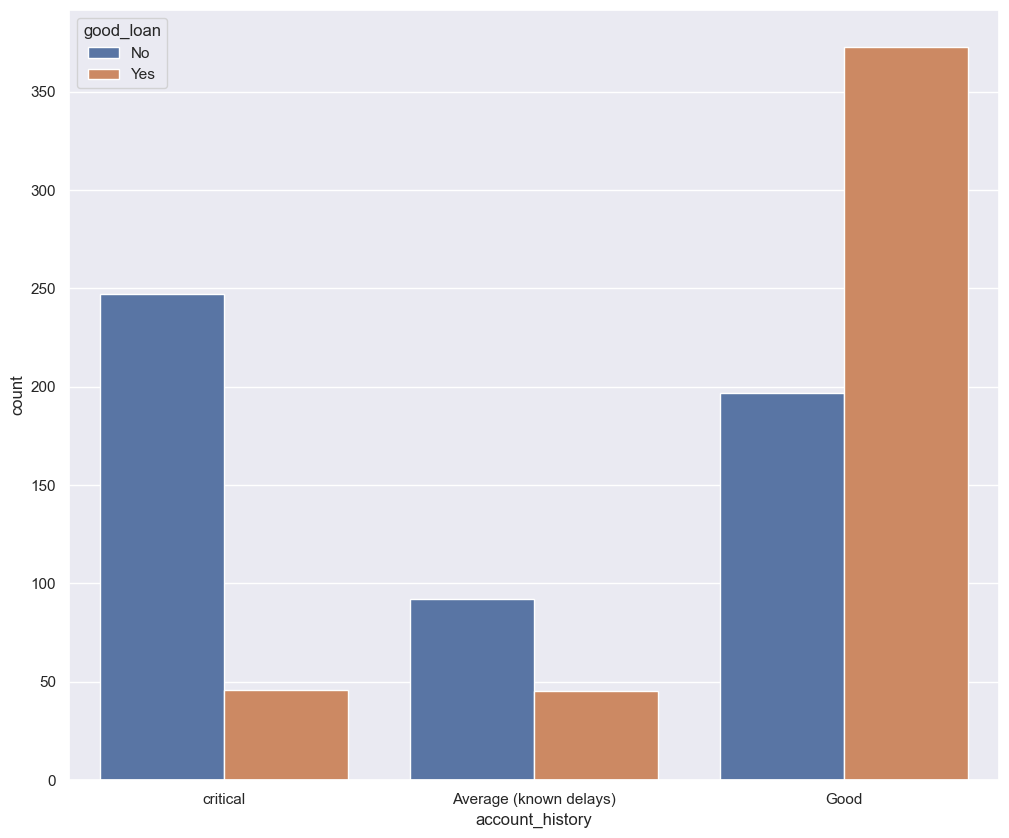

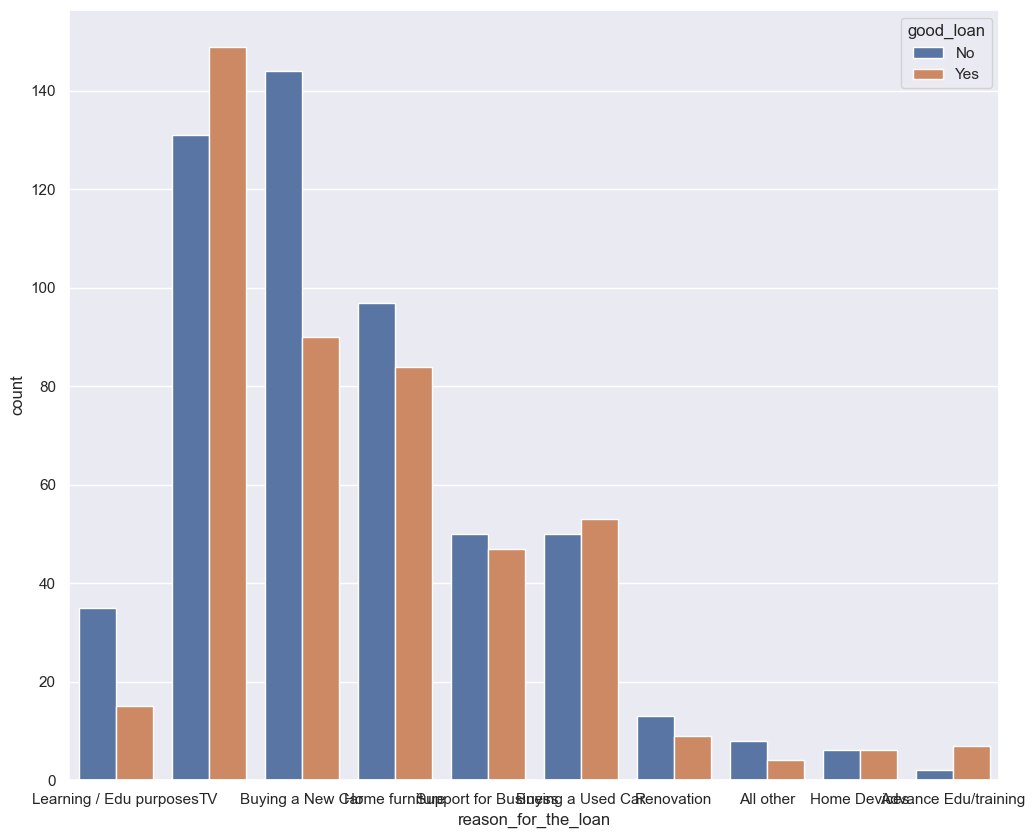

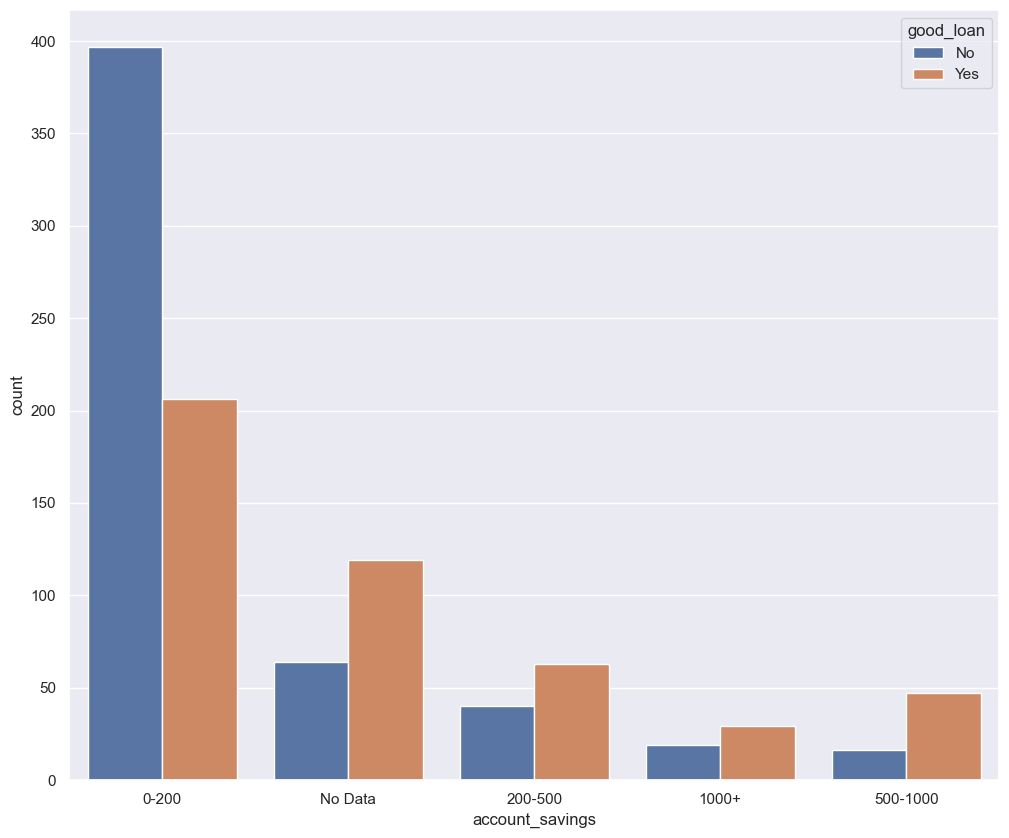

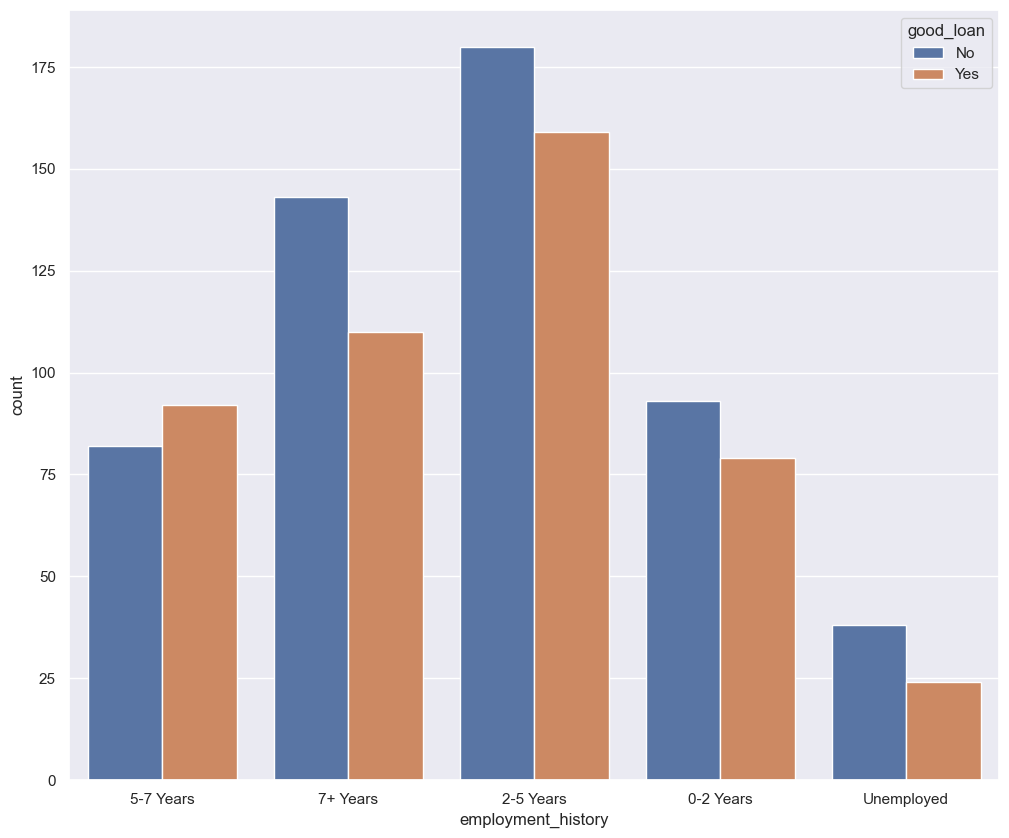

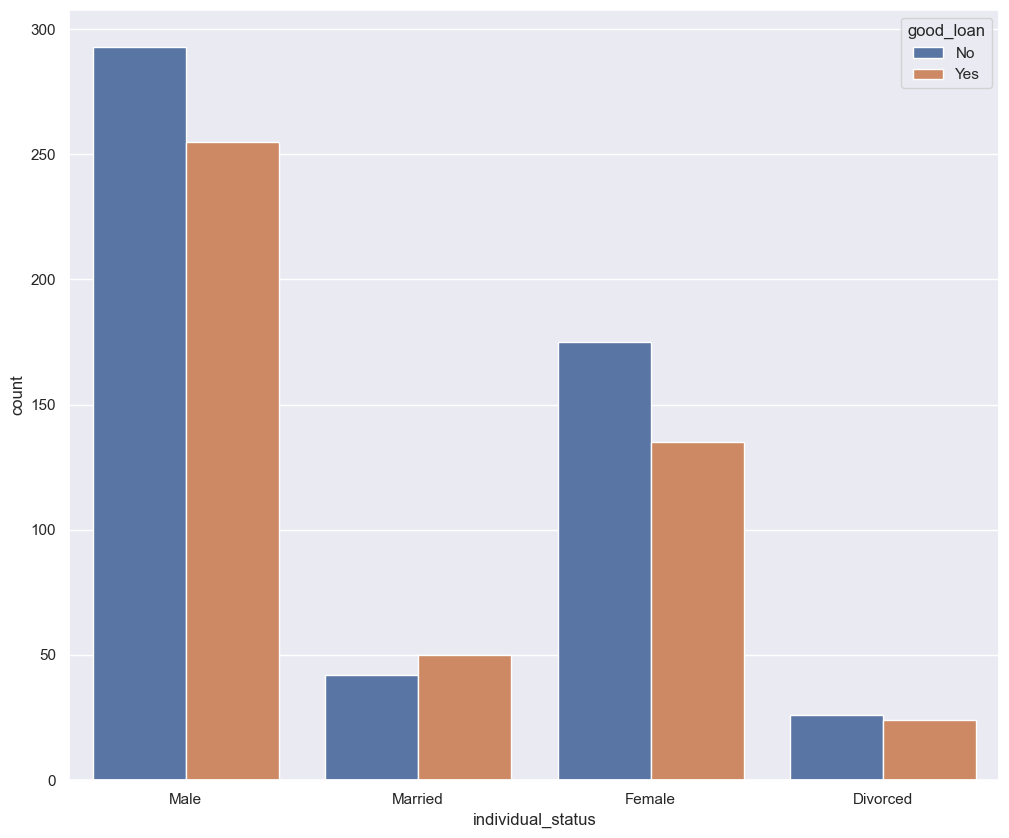

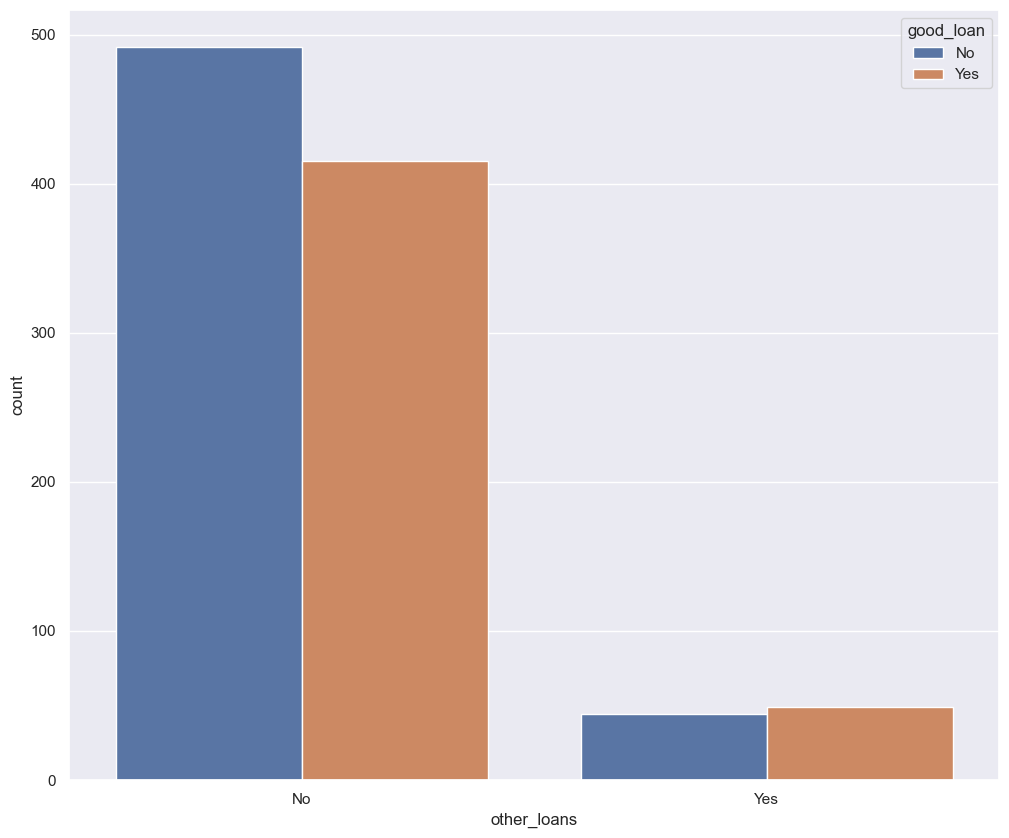

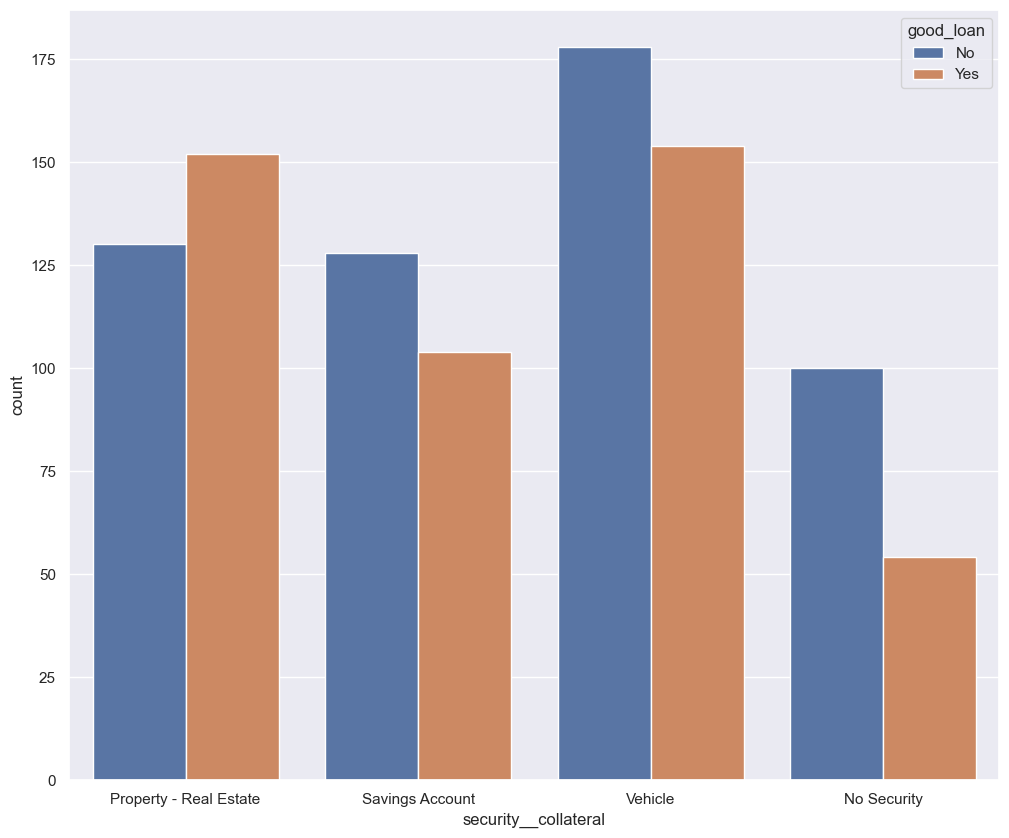

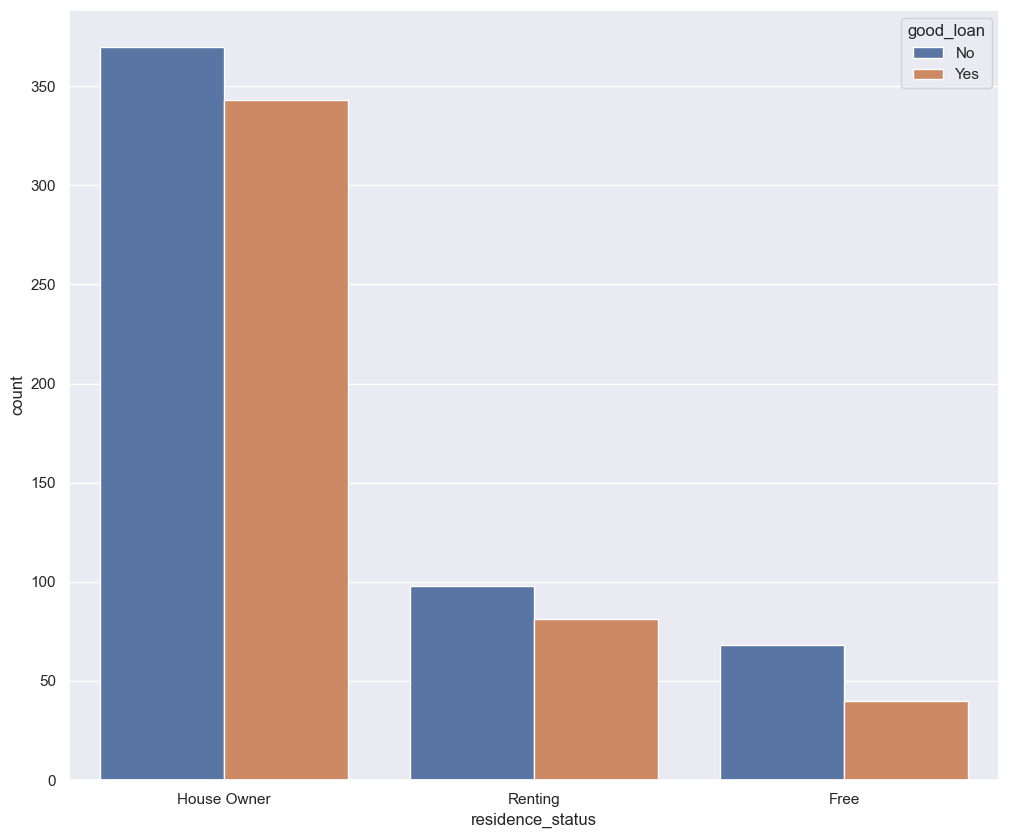

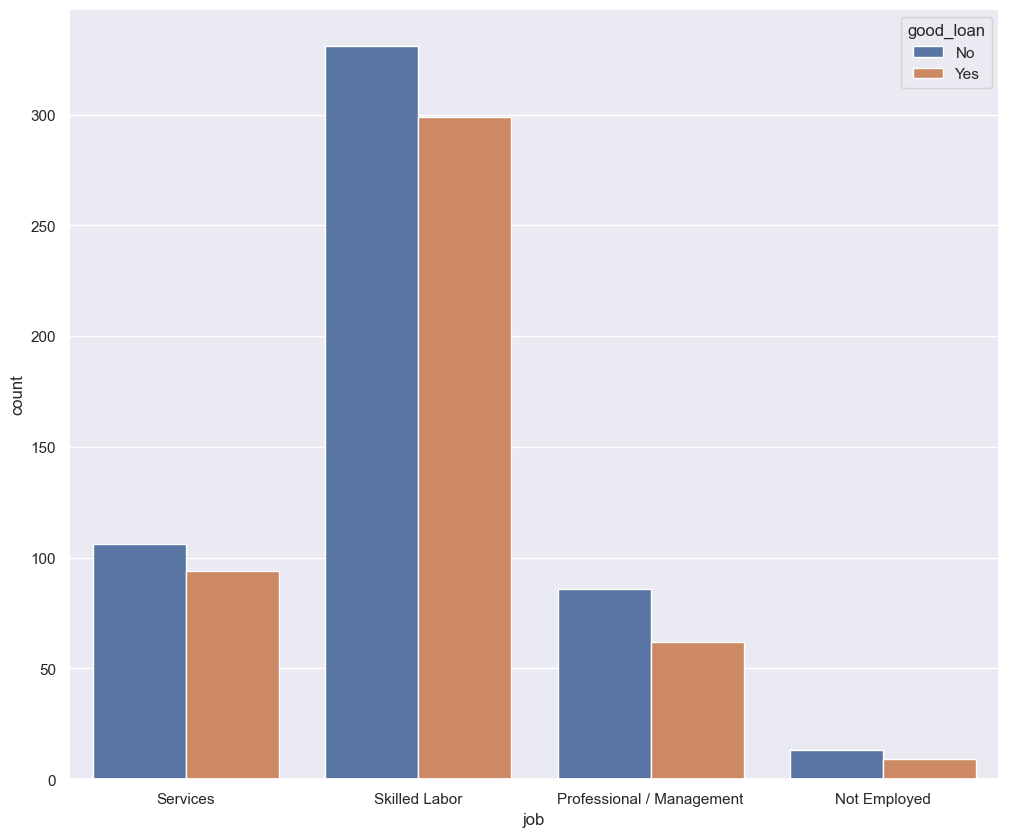

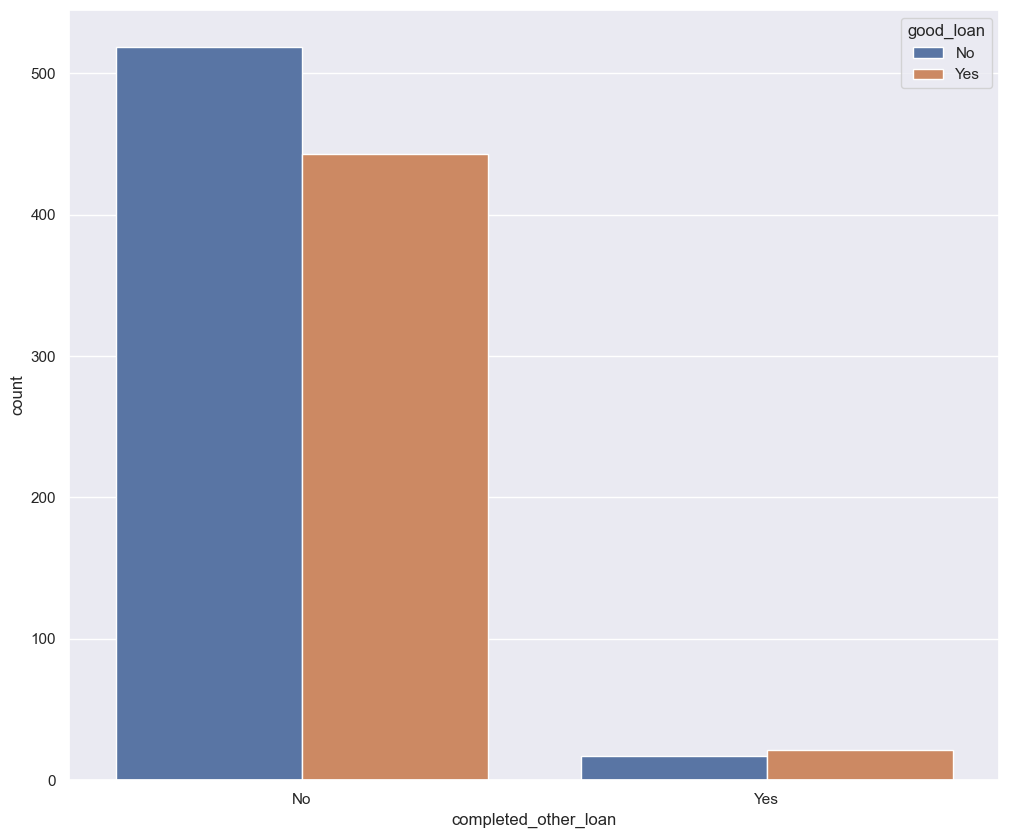

In [86]:
my_features = ['type_of_account', 'account_history', 'reason_for_the_loan', 'account_savings', 'employment_history',
               'individual_status', 'other_loans', 'security__collateral',
               'residence_status', 'job', 'completed_other_loan']

for f in my_features:
    sns.countplot(x=f, data=converted_to_pandas, hue='good_loan')
    plt.show()

Converting Strings to numbers so as to make the dta compatible with the algorithm.

In [87]:
my_dataset = my_dataset.withColumn("good_loan", when(col("good_loan") == "Yes", 1).otherwise(0))
my_dummies = pd.get_dummies(my_dataset.toPandas(), columns=my_features)
# my_dummies["good_loan"][my_dummies["good_loan"] == "Yes"] = 1
# my_dummies["good_loan"][my_dummies["good_loan"] == "No"] = 0
# my_dummies
# for pivot_col in ['account_history', 'reason_for_the_loan',
#             'account_savings', 'employment_history', 'individual_status',
#             'other_loans', 'security__collateral',
#             'residence_status', 'job', 'completed_other_loan']:
    
#     test = my_dataset. \

#         groupBy('loan_amount','age','good_loan'). \
#         pivot(pivot_col). \
#         agg(count('*')). \
#         fillna(0)

# my_dummies_pyspark = spark.createDataFrame(my_dummies)
cols=[]
for column in my_dummies.columns:
    new_column = str(column)
    new_column = re.sub('[\W_]+', ' ', new_column).strip().replace(" ","_").lower()
    cols.append(new_column)


my_dummies.columns = cols


# Feature Selection
We need to know which feature impacts our output the most.

In [88]:
X = my_dummies.drop("good_loan", axis=1).values
y = my_dummies["good_loan"]
y = y.astype(int)

# Decision Tree Classifier

Decision tree learning is a supervised learning approach used in statistics, data mining and machine learning. In this formalism, a classification or regression decision tree is used as a predictive model to draw conclusions about a set of observations.

Tree models where the target variable can take a discrete set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. More generally, the concept of regression tree can be extended to any kind of object equipped with pairwise dissimilarities such as categorical sequences.[1]

Decision trees are among the most popular machine learning algorithms given their intelligibility and simplicity.[2]

In decision analysis, a decision tree can be used to visually and explicitly represent decisions and decision making. In data mining, a decision tree describes data (but the resulting classification tree can be an input for decision making).

# Tree Based Estimators

Tree based estimators like decision tree and random forest, help getting feature importances.

In [89]:
dt = DecisionTreeClassifier(random_state=15, criterion='entropy', max_depth=10)
dt.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=15)

Get importnce of each feature on the variable y.

In [90]:
fi_col = []
fi = []
for i, column in enumerate(my_dummies.drop("good_loan", axis=1)):
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])


my_zip = zip(fi_col, fi)
my_feature_importances = pd.DataFrame(my_zip, columns=["feature Column", "Importance"]).sort_values("Importance", ascending=False).reset_index()


my_important_features = my_feature_importances.where(my_feature_importances["Importance"] > 0)["feature Column"].dropna()

# Splitting the RAW data

In [91]:
# numpy array of features

X = my_dummies[my_important_features].values
y = my_dummies["good_loan"]
y = y.astype(int).values

# Hold Out Validation

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=15)

print(f"Train Set : X = {X_train.shape}, Y = {y_train.shape}")
print(f"Test Set : X = {X_test.shape}, Y = {y_test.shape}")


X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, train_size=0.9, random_state=15)

print(f"\nNew Train Set : X = {X_train.shape}, Y = {y_train.shape}")
print(f"New Test Set : X = {X_test.shape}, Y = {y_test.shape}")
print(f"CV Set : X = {X_valid.shape}, Y = {y_valid.shape}")




Train Set : X = (800, 40), Y = (800,)
Test Set : X = (200, 40), Y = (200,)

New Train Set : X = (720, 40), Y = (720,)
New Test Set : X = (200, 40), Y = (200,)
CV Set : X = (80, 40), Y = (80,)


# Investigate y's

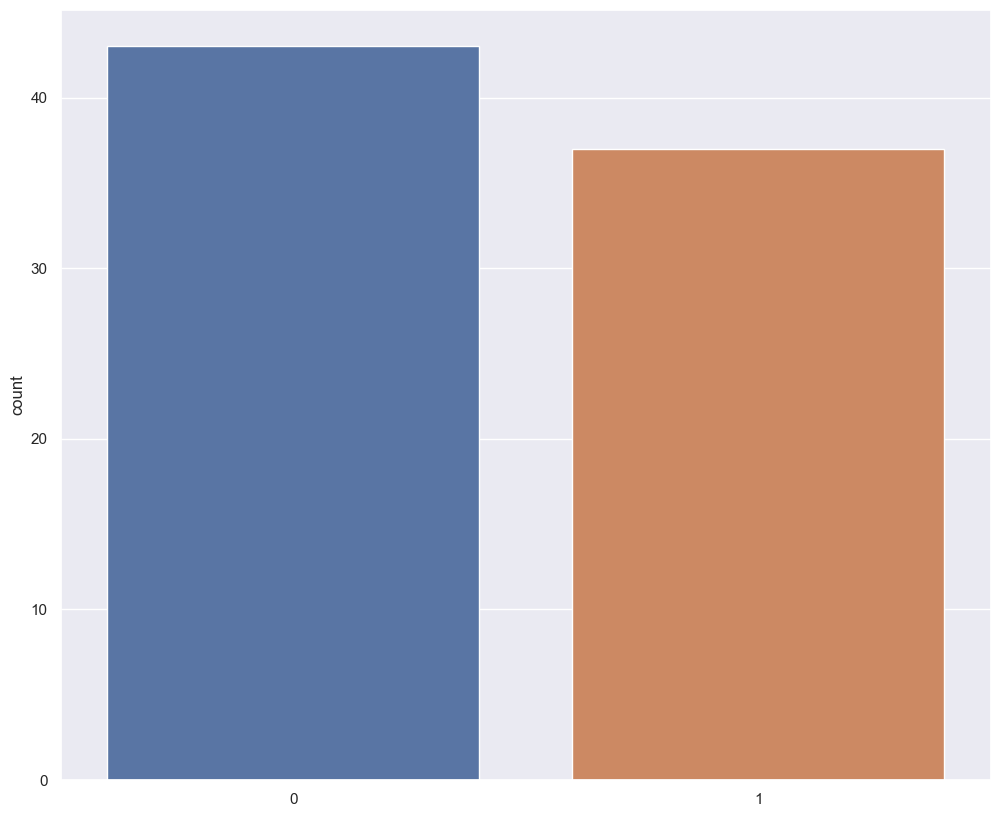

In [93]:
ax = sns.countplot(x=y_valid)

# Logistic Regression

Logistic regression, despite its name, is a classification algorithm rather than regression algorithm. Based on a given set of independent variables, it is used to estimate discrete value (0 or 1, yes/no, true/false). It is also called logit or MaxEnt Classifier.

Basically, it measures the relationship between the categorical dependent variable and one or more independent variables by estimating the probability of occurrence of an event using its logistics function.

sklearn.linear_model.LogisticRegression is the module used to implement logistic regression.





random_state − int, RandomState instance or None, optional, default = none, This parameter represents the seed of the pseudo random number generated which is used while shuffling the data.

solver − str, {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘saag’, ‘saga’}, optional, default = ‘liblinear’ This parameter represents which algorithm to use in the optimization problem. Followings are the properties of options under this parameter
    liblinear − It is a good choice for small datasets. It also handles L1 penalty. For multiclass problems, it is limited to one-versus-rest schemes.

    newton-cg − It handles only L2 penalty.

    lbfgs − For multiclass problems, it handles multinomial loss. It also handles only L2 penalty.

    saga − It is a good choice for large datasets. For multiclass problems, it also handles multinomial loss. Along with L1 penalty, it also supports ‘elasticnet’ penalty.

    sag − It is also used for large datasets. For multiclass problems, it also handles multinomial loss.





In [94]:
log_reg = LogisticRegression(random_state=10, solver = 'lbfgs')
log_reg.fit(X_train, y_train)

# Methods we can use in Logistic

# predict - Predict class labels for samples in X
log_reg.predict(X_train)
y_pred = log_reg.predict(X_train)

print(y_pred)

# predict_proba - Probability estimates
pred_proba = log_reg.predict_proba(X_train)
print(pred_proba)

 	
# coef_ − array, shape(n_features,) or (n_classes, n_features)
# It is used to estimate the coefficients of the features in the decision function. When the given problem is binary, it is of the shape (1, n_features).
print(log_reg.coef_)


[0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1
 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0
 1 1 1 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 1
 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0
 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0
 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0
 0 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0
 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0
 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 1 0 1
 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 1
 0 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0
 1 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1
 1 0 0 0 1 1 1 1 1 0 1 0 

# Model Evaluation

In [98]:
# score- Returns the mean accuracy on the given test data and labels - below

# Return the mean accuracy on the given test data and labels.

# In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.

# Parameters
# X : array-like of shape (n_samples, n_features)
#     Test samples.

# y : array-like of shape (n_samples,) or (n_samples, n_outputs)
#     True labels for X.

# sample_weight : array-like of shape (n_samples,), default=None
#     Sample weights.

# Returns
# score : float
#     Mean accuracy of self.predict(X) wrt. y.

# Accuracy on Train
# Mean accuracy of self.predict(X) wrt. y.
print("The Training Accuracy is: ", log_reg.score(X_train, y_train))

# Accuracy on Test
print("The Testing Accuracy is: ", log_reg.score(X_test, y_test))


# Classification Report
print(classification_report(y_train, y_pred))

	
# classes_ − array, shape(n_classes)

# It will provide a list of class labels known to the classifier.
print(log_reg.classes_)

The Training Accuracy is:  0.7791666666666667
The Testing Accuracy is:  0.75
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       387
           1       0.77      0.75      0.76       333

    accuracy                           0.78       720
   macro avg       0.78      0.78      0.78       720
weighted avg       0.78      0.78      0.78       720

[0 1]


In [96]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

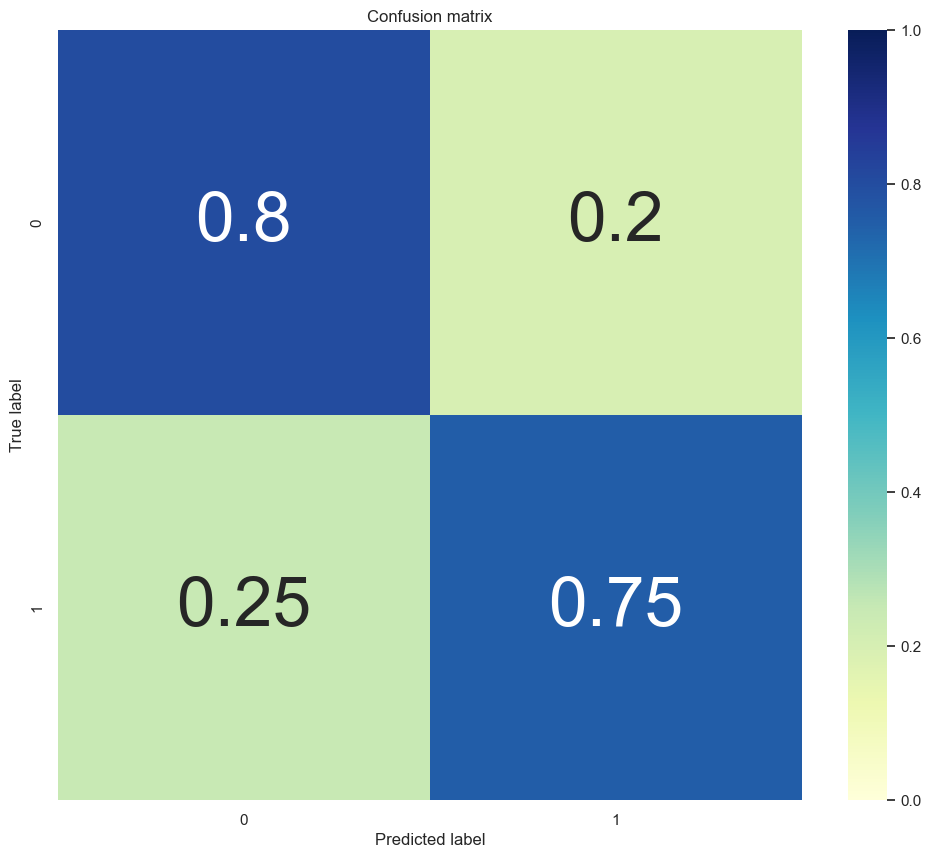

In [113]:
# Visualizing cm

cm = confusion_matrix(y_train, y_pred)

# [[311  76]
#  [ 83 250]]
# [[387]
#  [333]]
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(cm_norm, classes = log_reg.classes_, title='Confusion matrix')

In [110]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)


print(cm)
print("\n")



FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
print("The True Positive Rate is:", TPR)

# Precision or positive predictive value
PPV = TP / (TP + FP)
print("The Precision is:", PPV)

# False positive rate or False alarm rate
FPR = FP / (FP + TN)
print("The False positive rate is:", FPR)


# False negative rate or Miss Rate
FNR = FN / (FN + TP)
print("The False Negative Rate is: ", FNR)



##Total averages :
print("")
print("The average TPR is:", TPR.sum()/2)
print("The average Precision is:", PPV.sum()/2)
print("The average False positive rate is:", FPR.sum()/2)
print("The average False Negative Rate is:", FNR.sum()/2)


[[311  76]
 [ 83 250]]


[83 76]
[76 83]
